In [ ]:
import os
import obspy
from obspy import read
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.trigger import classic_sta_lta
DATA_DIR = '/app/data'


In [ ]:
def read_seismic_files(directory):
    st = obspy.Stream()
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file matches the expected naming pattern
            # At least 5 parts in the filename
            if len(file.split('.')) >= 5:  
                file_path = os.path.join(root, file)
                try:
                    st += read(file_path)
                except Exception as e:
                    print(f"Error reading file {file}: {str(e)}")
    return st

In [ ]:
def display_information(stream):
    stream = read_seismic_files(DATA_DIR)
    
    print(f"Number of traces: {len(stream)}")
    station_ids = set(tr.stats.station for tr in stream)
    print("Unique station IDs in the dataset:")
    for station_id in sorted(station_ids):
        print(station_id)
    
    for i, tr in enumerate(stream):
        print(f"\nTrace {i + 1}:")
        print(f"Station: {tr.stats.station}")
        print(f"Channel: {tr.stats.channel}")
        print(f"Start time: {tr.stats.starttime}")
        print(f"End time: {tr.stats.endtime}")
        print(f"Number of samples: {tr.stats.npts}")
        print(f"Sampling rate: {tr.stats.sampling_rate} Hz")
display_information(stream)


In [ ]:
def plat_single_trace(stream):
    stream[0].plot(type='relative', outfile=None, fig=plt.figure(figsize=(12, 6)))

    # Adjust the title and grid after ObsPy has created the plot
    plt.title(f"Seismic Data: {stream[0].stats.station} - {stream[0].stats.channel}")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.show()
plat_single_trace(stream)

In [ ]:
def plot_multiple_traces(stream):
    fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
    fig.suptitle("Seismic Data: Multiple Traces", fontsize=16)
     # Plot first 5 traces
    for i, tr in enumerate(stream[:5]): 
        ax = axes[i]
        times = tr.times()
        ax.plot(times, tr.data, 'k')
        ax.set_title(f"{tr.id}", fontsize=10)
        ax.set_ylabel("Amplitude (counts)")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Set y-axis limits symmetrically
        max_amp = max(abs(tr.data.max()), abs(tr.data.min()))
        ax.set_ylim(-max_amp, max_amp)
        
        # Only show x-axis label for the bottom subplot
        if i == 4:
            ax.set_xlabel("Time (seconds)")
        
        # Adjust y-axis tick label font size
        ax.tick_params(axis='y', labelsize=8)
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  
    plt.show()
plot_multiple_traces(stream)

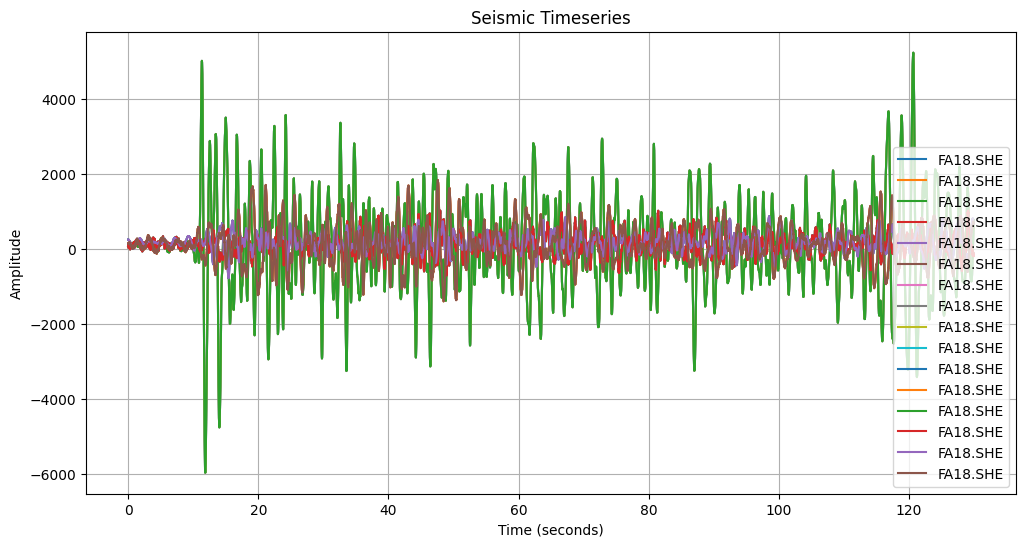

In [15]:
def plot_timeseries(stream, station=None, channel=None):
    if station and channel:
        st_filtered = stream.select(station=station, channel=channel)
    else:
        st_filtered = stream

    fig, ax = plt.subplots(figsize=(12, 6))
    for tr in st_filtered:
        times = tr.times()
        ax.plot(times, tr.data, label=f'{tr.stats.station}.{tr.stats.channel}')
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Seismic Timeseries')
    ax.legend()
    ax.grid(True)
    plt.show()

# Example usage:
plot_timeseries(stream)

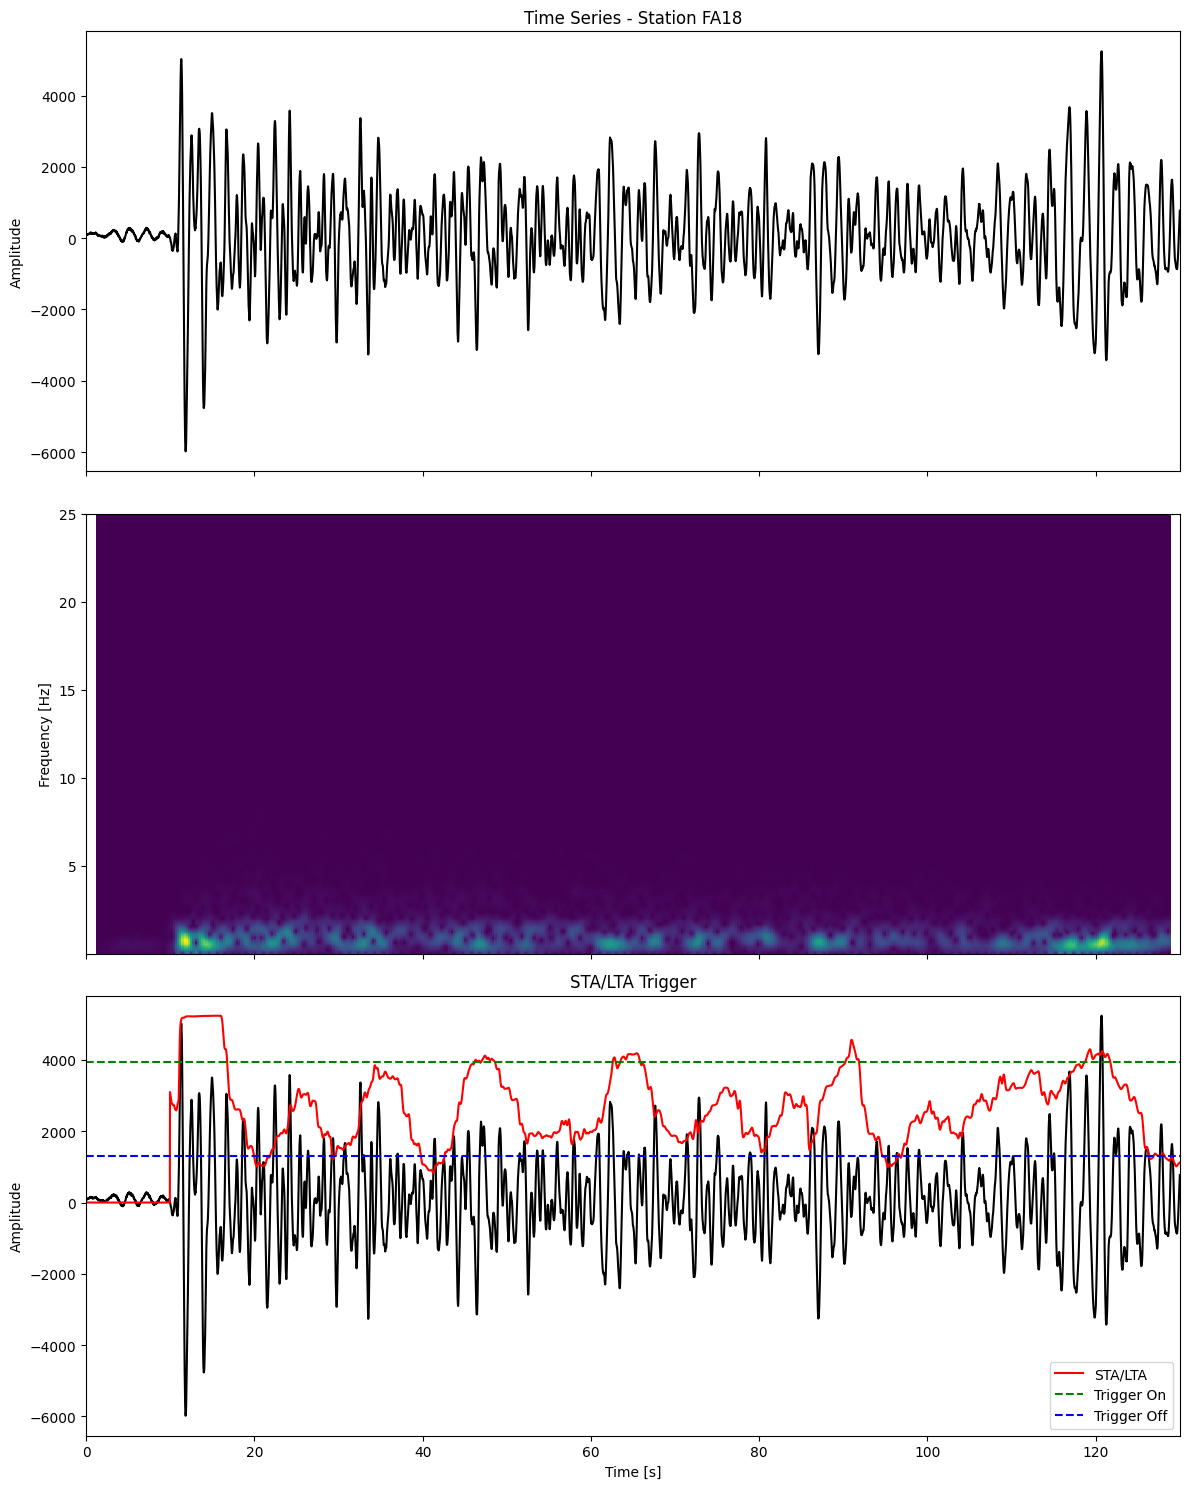

In [13]:
def plot_event_detection(stream, station_id):
    trace = stream.select(station=station_id)[0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    # Time series plot
    times = trace.times()
    ax1.plot(times, trace.data, 'k')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'Time Series - Station {station_id}')
    
    # Spectrogram
    spectrogram(trace.data, samp_rate=trace.stats.sampling_rate, axes=ax2)
    ax2.set_ylabel('Frequency [Hz]')
    
    # STA/LTA trigger
    sta_length = int(5 * trace.stats.sampling_rate)
    lta_length = int(10 * trace.stats.sampling_rate)
    cft = classic_sta_lta(trace.data, sta_length, lta_length)
    
    ax3.plot(times, trace.data, 'k')
    ax3.plot(times, cft * np.max(trace.data) / np.max(cft), 'r', label='STA/LTA')
    ax3.axhline(1.5 * np.max(trace.data) / np.max(cft), color='g', linestyle='--', label='Trigger On')
    ax3.axhline(0.5 * np.max(trace.data) / np.max(cft), color='b', linestyle='--', label='Trigger Off')
    ax3.set_ylabel('Amplitude')
    ax3.set_xlabel('Time [s]')
    ax3.legend()
    ax3.set_title('STA/LTA Trigger')
    
    plt.tight_layout()
    plt.show()
station_id = stream[0].stats.station  # Use the first station in the stream
plot_event_detection(stream, station_id)

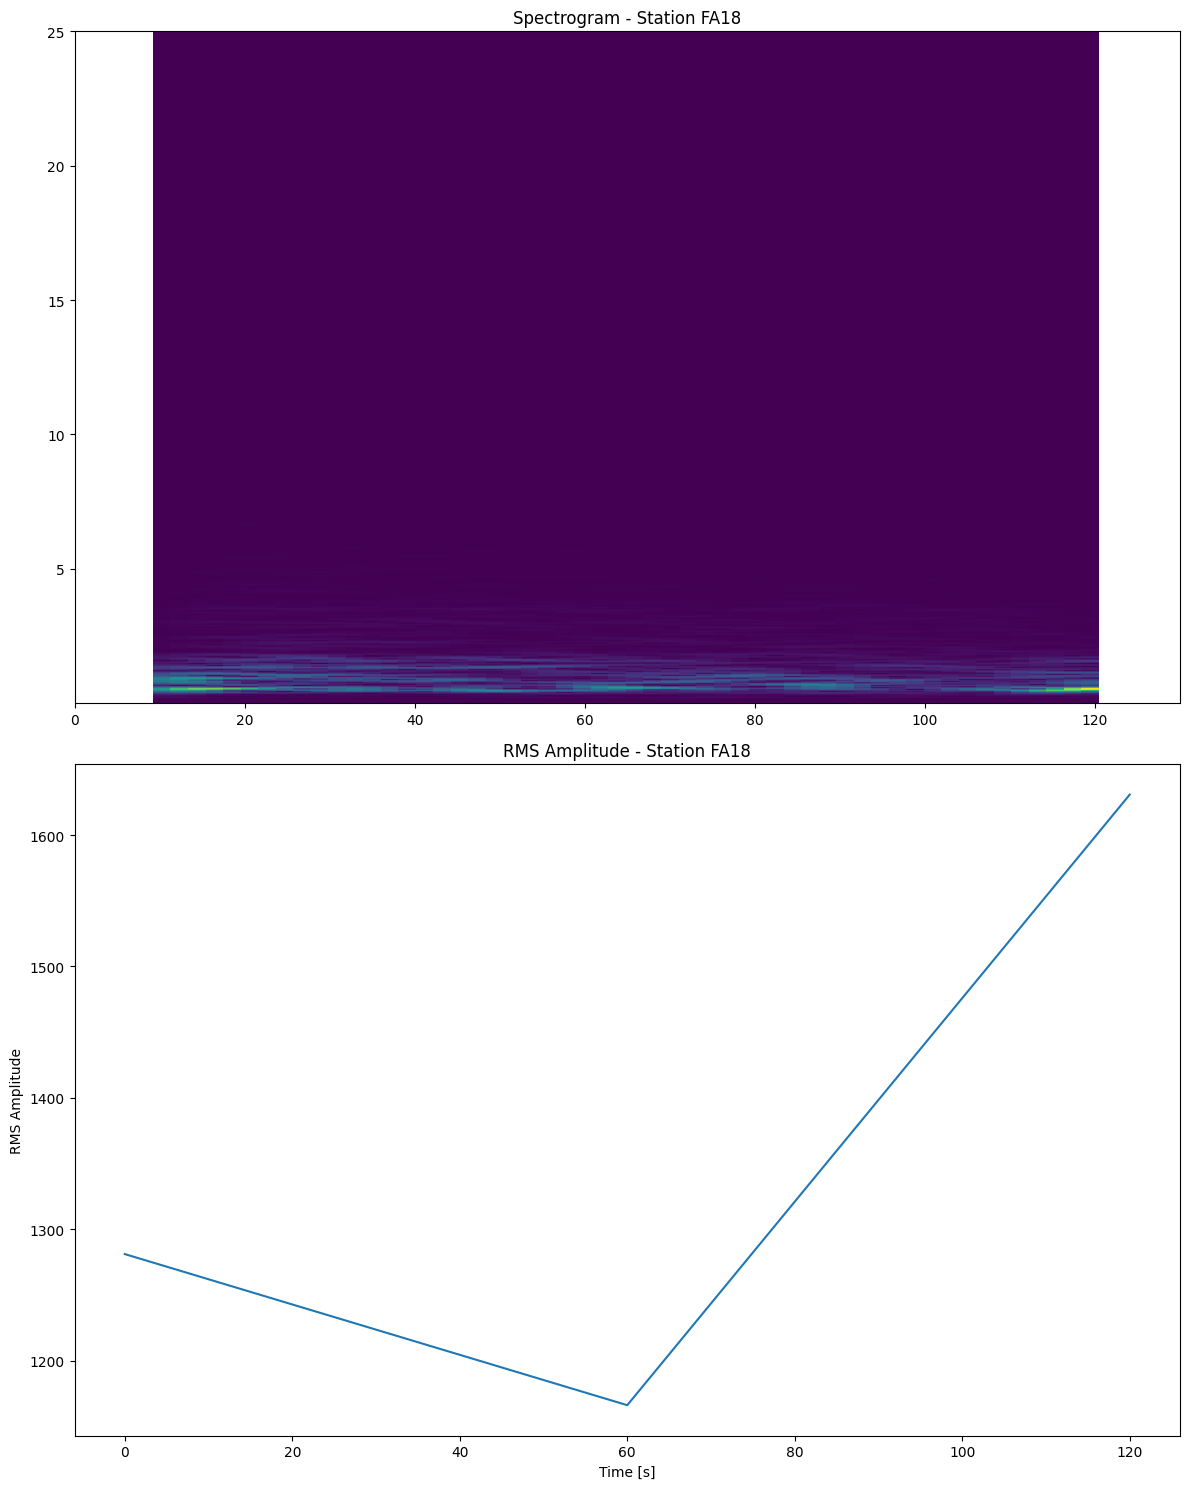

In [16]:
def plot_data_quality(stream, station_id):
    trace = stream.select(station=station_id)[0]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15))
    
    # Spectrogram plot
    spectrogram(trace.data, samp_rate=trace.stats.sampling_rate, 
                wlen=trace.stats.sampling_rate // 2, per_lap=0.9,
                cmap='viridis', axes=ax1)
    ax1.set_title(f'Spectrogram - Station {station_id}')
    
    # RMS amplitude plot
    window_size = int(60 * trace.stats.sampling_rate)  # 1-minute windows
    rms = np.array([np.sqrt(np.mean(trace.data[i:i+window_size]**2)) 
                    for i in range(0, len(trace.data), window_size)])
    times = trace.times()[::window_size]
    ax2.plot(times, rms)
    ax2.set_title(f'RMS Amplitude - Station {station_id}')
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('RMS Amplitude')
    
    plt.tight_layout()
    plt.show()
plot_data_quality(stream, station_id)

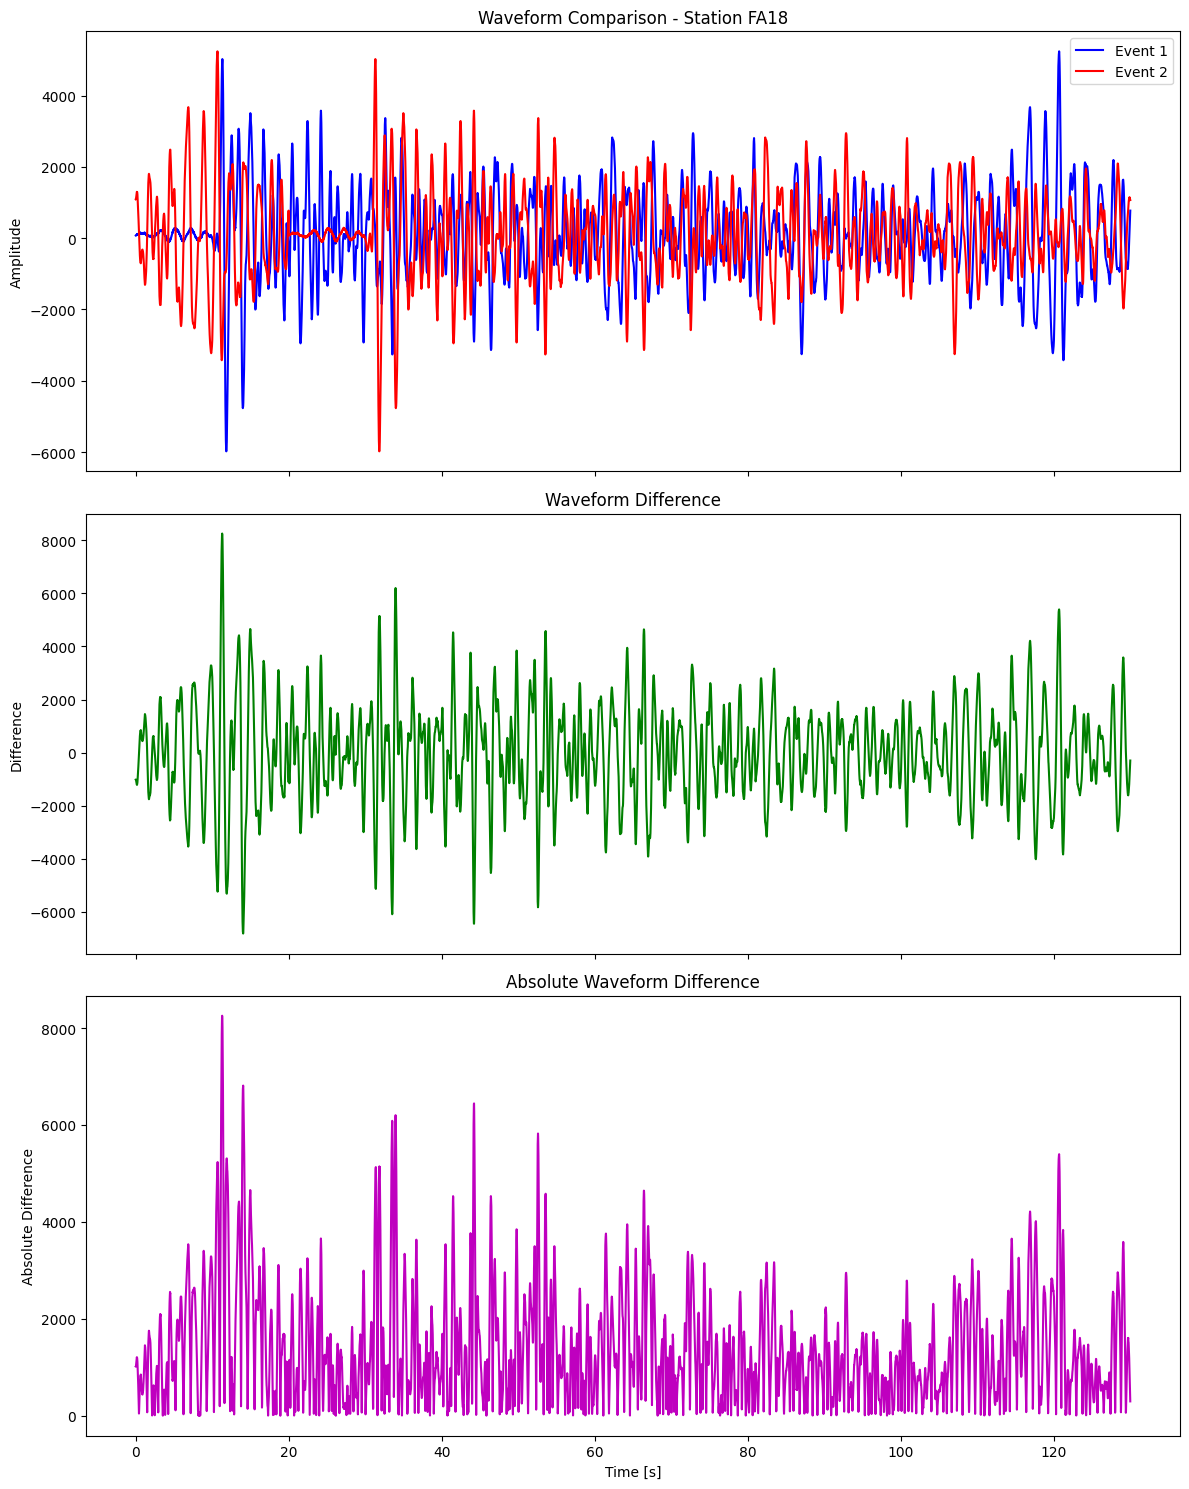

In [17]:
def plot_waveform_comparison(stream1, stream2, station_id):
    trace1 = stream1.select(station=station_id)[0]
    trace2 = stream2.select(station=station_id)[0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    times = trace1.times()
    ax1.plot(times, trace1.data, 'b', label='Event 1')
    ax1.plot(times, trace2.data, 'r', label='Event 2')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'Waveform Comparison - Station {station_id}')
    ax1.legend()
    
    ax2.plot(times, trace1.data - trace2.data, 'g')
    ax2.set_ylabel('Difference')
    ax2.set_title('Waveform Difference')
    
    ax3.plot(times, np.abs(trace1.data - trace2.data), 'm')
    ax3.set_ylabel('Absolute Difference')
    ax3.set_xlabel('Time [s]')
    ax3.set_title('Absolute Waveform Difference')
    
    plt.tight_layout()
    plt.show()
stream2 = stream.copy()
stream2[0].data = np.roll(stream2[0].data, 1000)  # Shift the data by 1000 samples
plot_waveform_comparison(stream, stream2, station_id)

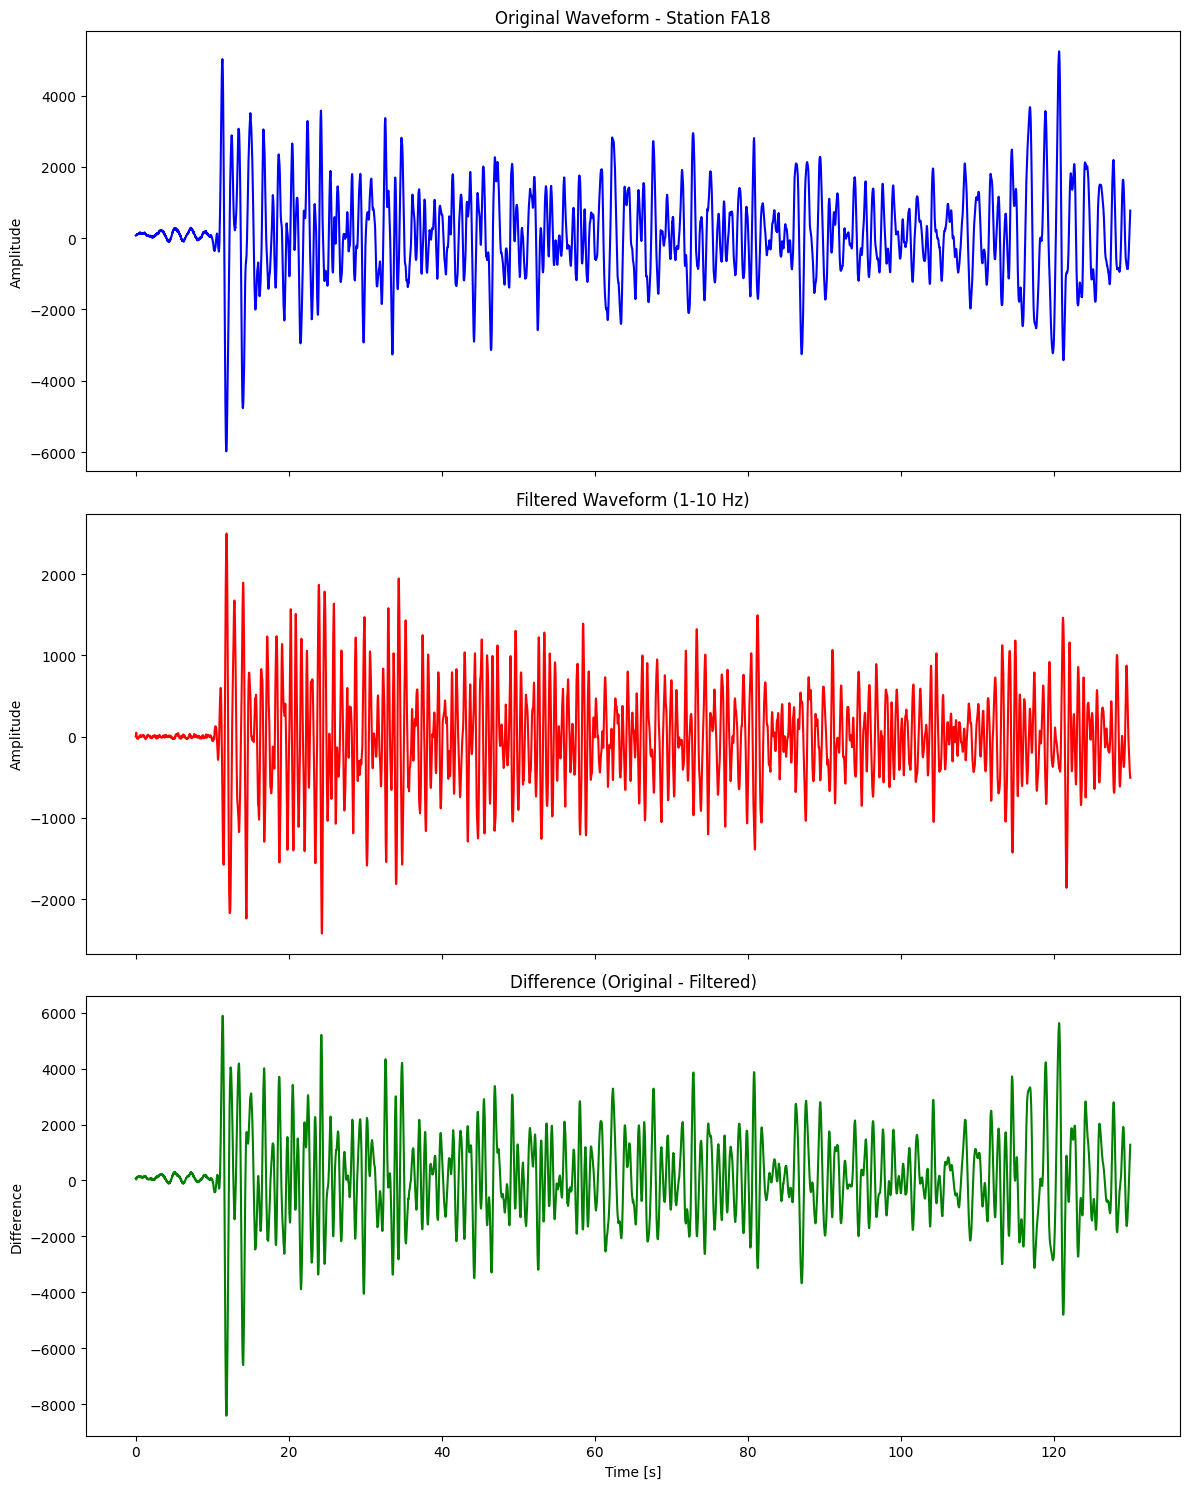

In [14]:
def plot_signal_processing(stream, station_id, freqmin, freqmax):
    trace = stream.select(station=station_id)[0]
    filtered_trace = trace.copy()
    filtered_trace.filter('bandpass', freqmin=freqmin, freqmax=freqmax)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    times = trace.times()
    ax1.plot(times, trace.data, 'b')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'Original Waveform - Station {station_id}')
    
    ax2.plot(times, filtered_trace.data, 'r')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Filtered Waveform ({freqmin}-{freqmax} Hz)')
    
    ax3.plot(times, trace.data - filtered_trace.data, 'g')
    ax3.set_ylabel('Difference')
    ax3.set_xlabel('Time [s]')
    ax3.set_title('Difference (Original - Filtered)')
    
    plt.tight_layout()
    plt.show()
plot_signal_processing(stream, station_id, freqmin=1, freqmax=10)  # Bandpass filter 1-10 Hz